# Gold Price Prediction - Regression Model

## Problem Statement

To build a machine learning model to predict the daily closing price of Gold (GLD) using related financial indicators such as stock indices (e.g., SPX), oil prices (USO), silver prices (SLV), and currency rates (EUR/USD). 

**Real‑world problem:** Gold is widely used as a hedge against inflation and market risk. Accurate short‑term prediction of gold prices can help traders, investors, and financial analysts make better buy/sell decisions and manage portfolio risk.

*Target variable:* GLD (Gold price).  
*Input features:* All other numeric columns from the dataset.


### Importing the Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
import xgboost as xgb
import shap
import warnings
warnings.filterwarnings('ignore')


## Data Collection and Preprocessing

In [ ]:
gold_data = pd.read_csv('gold price dataset.csv')

In [ ]:
gold_data.head()

,Date,SPX,GLD,USO,SLV,EUR/USD
0,01/02/2008,1447.160034,84.860001,78.470001,15.180,1.471692
1,01/03/2008,1447.160034,85.570000,78.370003,15.285,1.474491
2,01/04/2008,1411.630005,85.129997,77.309998,15.167,1.475492
3,01/07/2008,1416.180054,84.769997,75.500000,15.053,1.468299
4,01/08/2008,1390.189941,86.779999,76.059998,15.590,1.557099


In [ ]:
gold_data.tail()

,Date,SPX,GLD,USO,SLV,EUR/USD
2285,05/08/2018,2671.919922,124.589996,14.0600,15.5100,1.186789
2286,05/09/2018,2697.790039,124.330002,14.3700,15.5300,1.184722
2287,05/10/2018,2723.070068,125.180000,14.4100,15.7400,1.191753
2288,5/14/2018,2730.129883,124.489998,14.3800,15.5600,1.193118
2289,5/16/2018,2725.780029,122.543800,14.4058,15.4542,1.182033


In [ ]:
gold_data.shape

(2290, 6)

In [ ]:
gold_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     2290 non-null   object 
 1   SPX      2290 non-null   float64
 2   GLD      2290 non-null   float64
 3   USO      2290 non-null   float64
 4   SLV      2290 non-null   float64
 5   EUR/USD  2290 non-null   float64
dtypes: float64(5), object(1)
memory usage: 107.5+ KB


In [ ]:
#statistical summary of the dataset
gold_data.describe()

,SPX,GLD,USO,SLV,EUR/USD
count,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000
mean,1654.315776,122.732875,31.842221,20.084997,1.283653
std,519.111540,23.283346,19.523517,7.092566,0.131547
min,676.530029,70.000000,7.960000,8.850000,1.039047
25%,1239.874969,109.725000,14.380000,15.570000,1.171313
50%,1551.434998,120.580002,33.869999,17.268500,1.303297
75%,2073.010070,132.840004,37.827501,22.882500,1.369971
max,2872.870117,184.589996,117.480003,47.259998,1.598798


In [ ]:
gold_data.isnull().sum()

Date       0
SPX        0
GLD        0
USO        0
SLV        0
EUR/USD    0
dtype: int64

no need for handling missing values as the data is clean

In [ ]:
gold_data.duplicated().sum()

np.int64(0)

In [ ]:
gold_data['Date'] = pd.to_datetime(gold_data['Date'])
gold_data = gold_data.sort_values('Date')

In [ ]:
gold_data.head()

,Date,SPX,GLD,USO,SLV,EUR/USD
0,2008-01-02,1447.160034,84.860001,78.470001,15.180,1.471692
1,2008-01-03,1447.160034,85.570000,78.370003,15.285,1.474491
2,2008-01-04,1411.630005,85.129997,77.309998,15.167,1.475492
3,2008-01-07,1416.180054,84.769997,75.500000,15.053,1.468299
4,2008-01-08,1390.189941,86.779999,76.059998,15.590,1.557099


## Exploratory Data Analysis

Distribution plots of numerical features

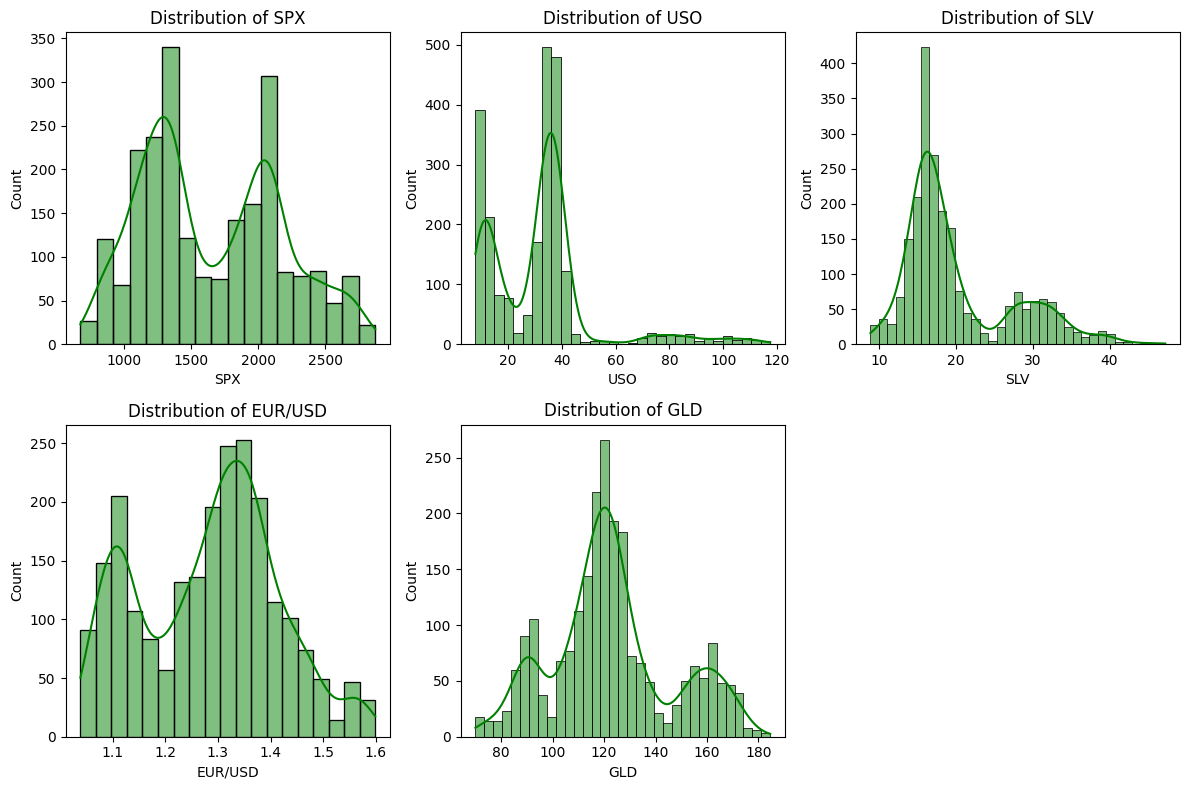

In [ ]:
numeric_cols = ['SPX', 'USO', 'SLV', 'EUR/USD', 'GLD']
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(gold_data[col], kde=True, color='green')
    plt.title(f"Distribution of {col}")
plt.tight_layout()


Outliers Detection using boxplots

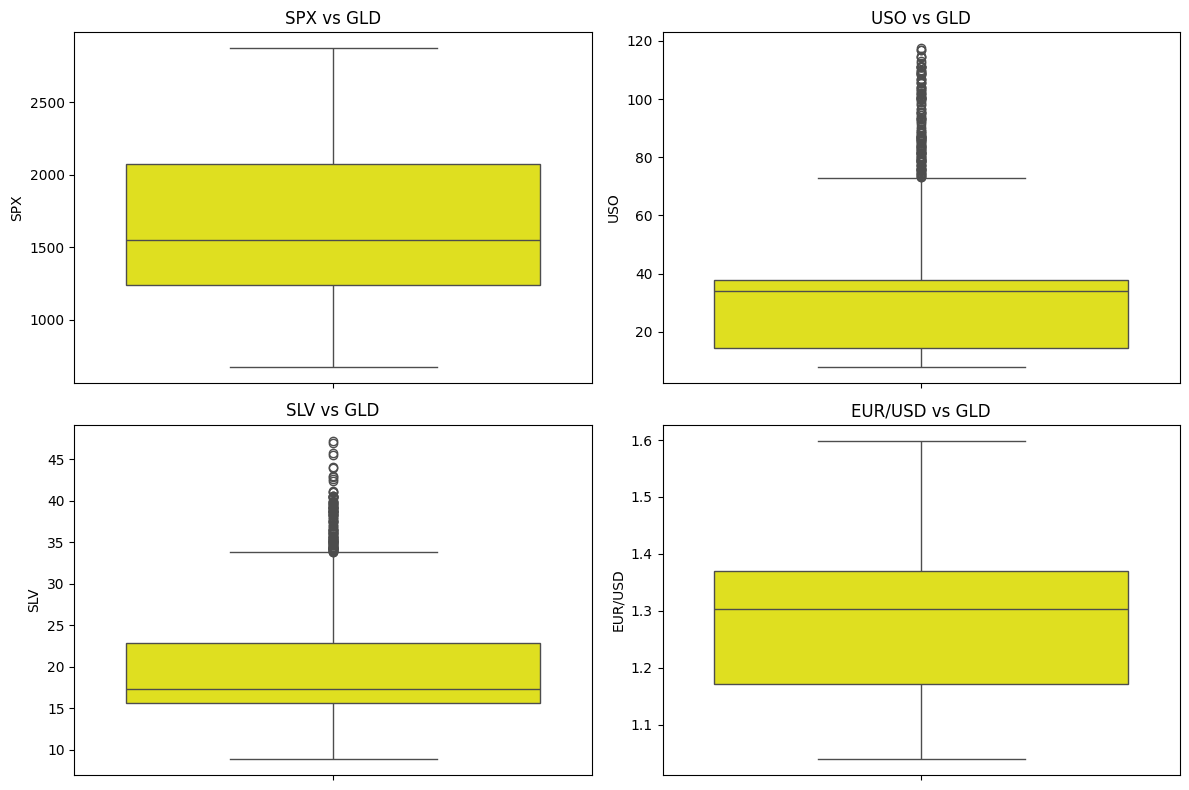

In [ ]:
features = ['SPX', 'USO', 'SLV', 'EUR/USD']

plt.figure(figsize=(12, 8))

for i, col in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=gold_data[col],color='yellow')
    plt.title(f"{col} vs GLD")

plt.tight_layout()
plt.show()


Correlation:
1. Positive Correlation
2. Negative Correlation

<Axes: >

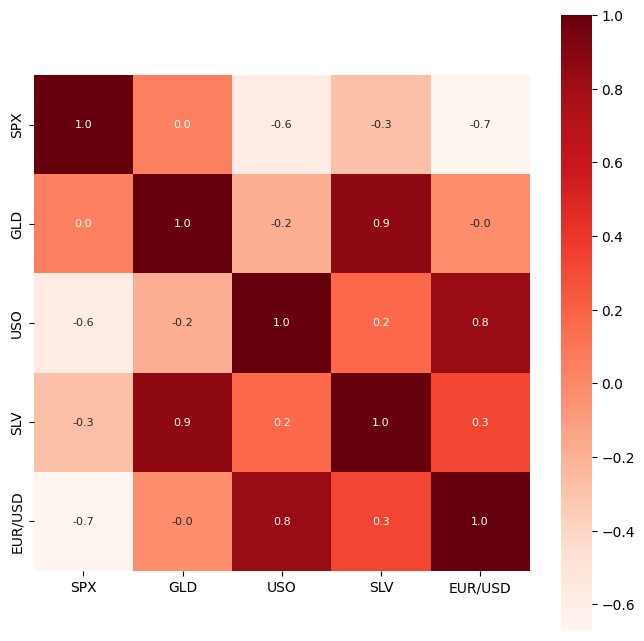

In [ ]:
correlation = gold_data.corr(numeric_only=True)

plt.figure(figsize = (8,8))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f',annot=True, annot_kws={'size':8}, cmap='Reds')

In [ ]:
# correlation values of GLD
print(correlation['GLD'])

SPX        0.049345
GLD        1.000000
USO       -0.186360
SLV        0.866632
EUR/USD   -0.024375
Name: GLD, dtype: float64


### Features vs Target relationship

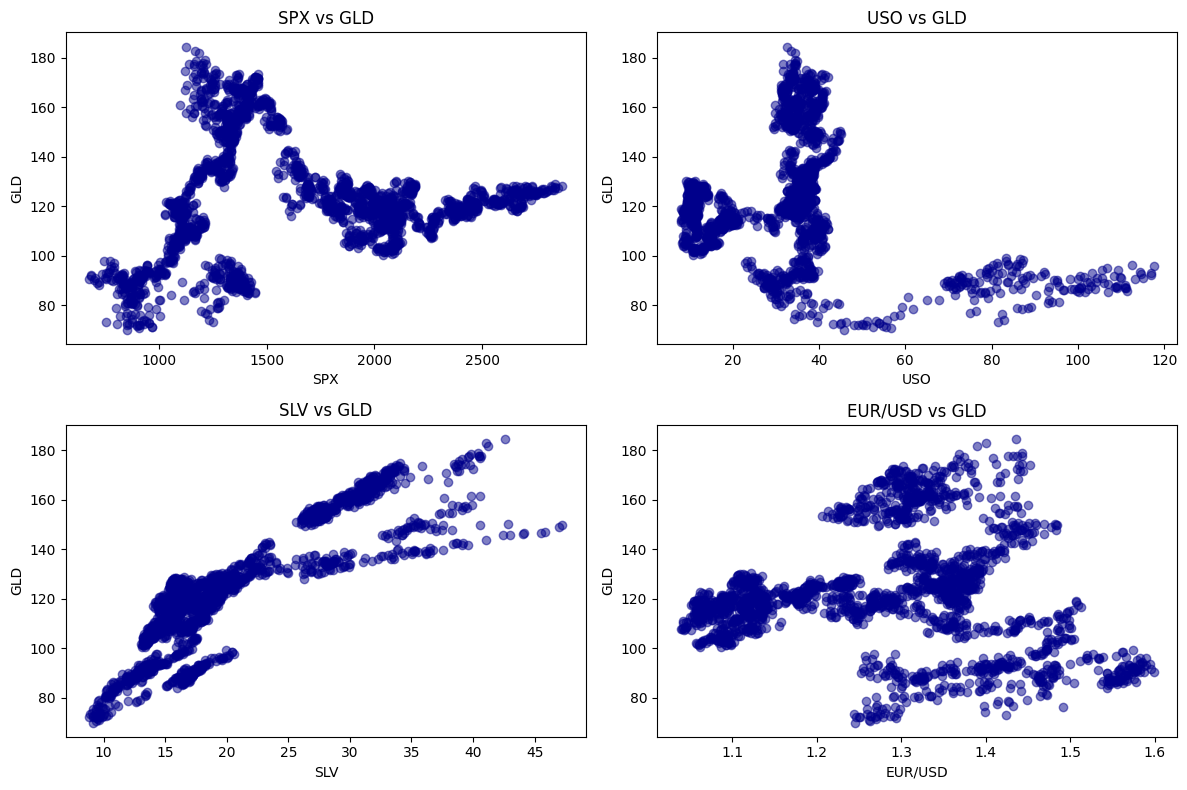

In [ ]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(['SPX', 'USO', 'SLV', 'EUR/USD'], 1):
    plt.subplot(2, 2, i)
    plt.scatter(gold_data[col], gold_data['GLD'], alpha=0.5, color='darkblue')
    plt.xlabel(col)
    plt.ylabel("GLD")
    plt.title(f"{col} vs GLD")
plt.tight_layout()


## Feature Engineering

To provide the model with richer information, we create a few **derived features** from the existing columns:

* `SPX_USO_ratio` – ratio between stock index and oil price.  
* `SLV_USO_ratio` – ratio between silver and oil prices.  
* `GLD_prev_diff` – day‑to‑day change in GLD (lag‑based signal).  

These engineered features may help the model capture additional non‑linear relationships.


In [ ]:
# Simple feature engineering
gold_data = gold_data.sort_values('Date')  # ensure chronological order

# Avoid division by zero by adding a very small constant
eps = 1e-6
gold_data['SPX_USO_ratio'] = gold_data['SPX'] / (gold_data['USO'] + eps)
gold_data['SLV_USO_ratio'] = gold_data['SLV'] / (gold_data['USO'] + eps)

# Lag-based feature: previous day's GLD and day-to-day difference
gold_data['GLD_prev'] = gold_data['GLD'].shift(1)
gold_data['GLD_prev_diff'] = gold_data['GLD'] - gold_data['GLD_prev']

gold_data = gold_data.dropna().reset_index(drop=True)

# Drop date column to prevent unnecessary errors
gold_data = gold_data.drop('Date', axis=1)

#### Splitting the Features and Target

In [ ]:
X = gold_data.drop('GLD',axis=1)
Y = gold_data['GLD']

In [ ]:
print(X)

              SPX        USO      SLV   EUR/USD  SPX_USO_ratio  SLV_USO_ratio  \
0     1447.160034  78.370003  15.2850  1.474491      18.465739       0.195036   
1     1411.630005  77.309998  15.1670  1.475492      18.259346       0.196184   
2     1416.180054  75.500000  15.0530  1.468299      18.757351       0.199377   
3     1390.189941  76.059998  15.5900  1.557099      18.277544       0.204970   
4     1409.130005  75.250000  15.5200  1.466405      18.725980       0.206246   
...           ...        ...      ...       ...            ...            ...   
2284  2671.919922  14.060000  15.5100  1.186789     190.036965       1.103129   
2285  2697.790039  14.370000  15.5300  1.184722     187.737638       1.080724   
2286  2723.070068  14.410000  15.7400  1.191753     188.970845       1.092297   
2287  2730.129883  14.380000  15.5600  1.193118     189.856029       1.082058   
2288  2725.780029  14.405800  15.4542  1.182033     189.214055       1.072776   

        GLD_prev  GLD_prev_

In [ ]:
print(Y)

0        85.570000
1        85.129997
2        84.769997
3        86.779999
4        86.550003
           ...    
2284    124.589996
2285    124.330002
2286    125.180000
2287    124.489998
2288    122.543800
Name: GLD, Length: 2289, dtype: float64


##### Splitting into Training data and Test Data

In [ ]:
X_train, X_test, Y_train, Y_test=train_test_split(X,Y, test_size=0.2, random_state=3)

# Scaling the data 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)


## Model Selection

### Linear Regression Model

In [ ]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, Y_train)
lr_pred = lr_model.predict(X_test_scaled)

# Evaluation
lr_r2 = metrics.r2_score(Y_test, lr_pred)
lr_mae = metrics.mean_absolute_error(Y_test, lr_pred)
lr_rmse = np.sqrt(metrics.mean_squared_error(Y_test, lr_pred))

print(f"Linear Regression R2: {lr_r2}")
print(f"Linear Regression MAE: {lr_mae}")
print(f"Linear Regression RMSE: {lr_rmse}")

# Coefficients
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': lr_model.coef_})
print(coef_df)


Linear Regression R2: 1.0
Linear Regression MAE: 1.0549542801678343e-14
Linear Regression RMSE: 1.499590044311058e-14
         Feature   Coefficient
0            SPX  7.275016e-15
1            USO  5.995204e-15
2            SLV -1.007527e-14
3        EUR/USD -1.582068e-15
4  SPX_USO_ratio -1.271205e-14
5  SLV_USO_ratio  7.799317e-15
6       GLD_prev  2.306848e+01
7  GLD_prev_diff  1.518961e+00


### XGBoost Model

In [ ]:
# XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Hyperparameter Tuning for XGBoost
xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9]
}

print("Tuning XGBoost...")
random_search_xgb = RandomizedSearchCV(xgb_model, param_distributions=xgb_params, n_iter=10, cv=5, verbose=1, n_jobs=1, random_state=42)
random_search_xgb.fit(X_train, Y_train)

best_xgb = random_search_xgb.best_estimator_
xgb_pred = best_xgb.predict(X_test)

# Evaluation
xgb_r2 = metrics.r2_score(Y_test, xgb_pred)
xgb_mae = metrics.mean_absolute_error(Y_test, xgb_pred)
xgb_rmse = np.sqrt(metrics.mean_squared_error(Y_test, xgb_pred))

print(f"Best XGBoost Params: {random_search_xgb.best_params_}")
print(f"XGBoost R2: {xgb_r2}")
print(f"XGBoost MAE: {xgb_mae}")
print(f"XGBoost RMSE: {xgb_rmse}")


Tuning XGBoost...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best XGBoost Params: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05}
XGBoost R2: 0.9994612386124635
XGBoost MAE: 0.3645509798141552
XGBoost RMSE: 0.5614907951956807


### Random Forest Model

Tuning Random Forest...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best RF Params: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': None}
Random Forest R2: 0.9986366288622738
Random Forest MAE: 0.4312514543013108
Random Forest RMSE: 0.8932056418666984


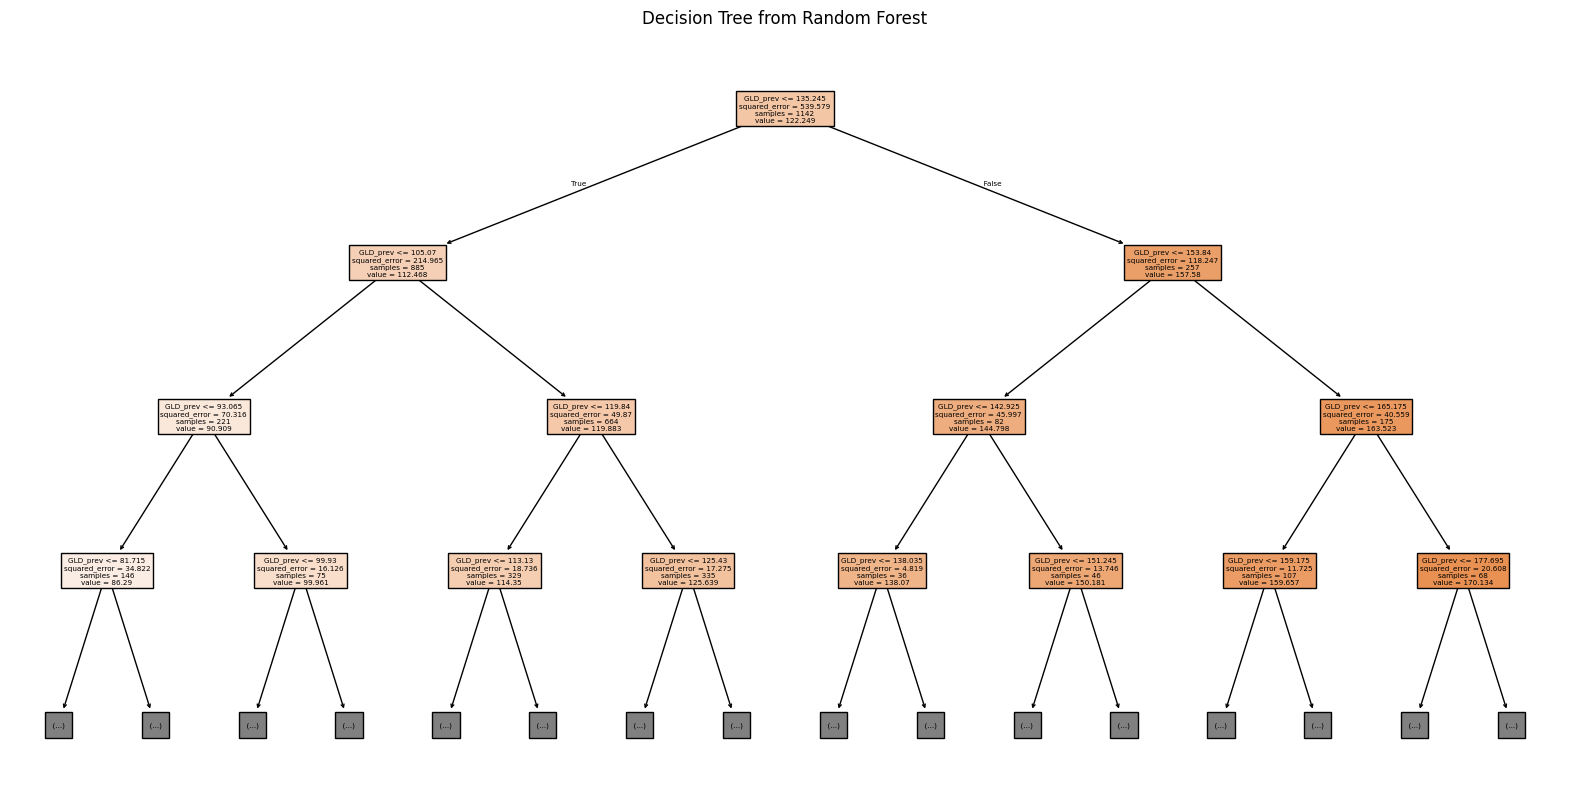

In [ ]:
regressor = RandomForestRegressor(n_estimators=100)

# Random Forest Tuning
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

print("Tuning Random Forest...")
rf_search = RandomizedSearchCV(RandomForestRegressor(random_state=2), param_distributions=rf_params, n_iter=5, cv=3, verbose=1, n_jobs=1, random_state=42)
rf_search.fit(X_train, Y_train)
best_rf = rf_search.best_estimator_
rf_pred = best_rf.predict(X_test)

# Evaluation
rf_r2 = metrics.r2_score(Y_test, rf_pred)
rf_mae = metrics.mean_absolute_error(Y_test, rf_pred)
rf_rmse = np.sqrt(metrics.mean_squared_error(Y_test, rf_pred))

print(f"Best RF Params: {rf_search.best_params_}")
print(f"Random Forest R2: {rf_r2}")
print(f"Random Forest MAE: {rf_mae}")
print(f"Random Forest RMSE: {rf_rmse}")

# Visualize one tree
plt.figure(figsize=(20,10))
plot_tree(best_rf.estimators_[0], feature_names=X.columns, filled=True, max_depth=3)
plt.title("Decision Tree from Random Forest")
plt.show()


## Model Training
### Random Forest Regressor

In [ ]:
regressor = RandomForestRegressor(n_estimators=100)

In [ ]:
# training the model
regressor.fit(X_train,Y_train)

RandomForestRegressor()

## Model Evaluation

In [ ]:
# prediction on Test Data
test_data_prediction = regressor.predict(X_test)

In [ ]:
print(test_data_prediction)

[108.27499959 120.42500035  90.85850103 121.46680035 161.33470128
  83.22159954 156.63110248 117.72510052 176.12170075 131.4490018
 126.32080003 125.83809955 142.43729784 165.73710044  81.05129919
 115.05940145 139.20349946 106.86970001  92.46070009 120.35080003
 119.92579978 120.14390033 117.7608992  116.83080135 126.23760125
 120.18430102 120.11570053 162.57160176 127.37579927 158.65810085
 135.17710066 117.48639803 166.04289992 157.25530046 115.78570028
 118.8398005  128.12320023 160.63920088 115.5931001  107.50439942
 115.28109961  86.42809833 164.82379792 167.91609989 125.68060123
 154.66960162 113.53690054 106.96850047  94.16140001  92.1374012
 107.63319998 155.37040149 122.94099856 122.88790095 126.35339912
 115.61260083 167.60850079 119.76990014 115.18629938  85.27339947
 164.53250175 124.62249977 173.29779833 110.2611001  132.67539825
 179.72999831 116.17690093 103.07200011 114.21139953 172.67280057
 125.35249876 117.38120101 125.47919945 124.92540055  98.71570033
  90.9449010

In [ ]:
# R squared error
error_score = metrics.r2_score(Y_test, test_data_prediction)
print("R squared error : ", error_score)

R squared error :  0.9986179822219109


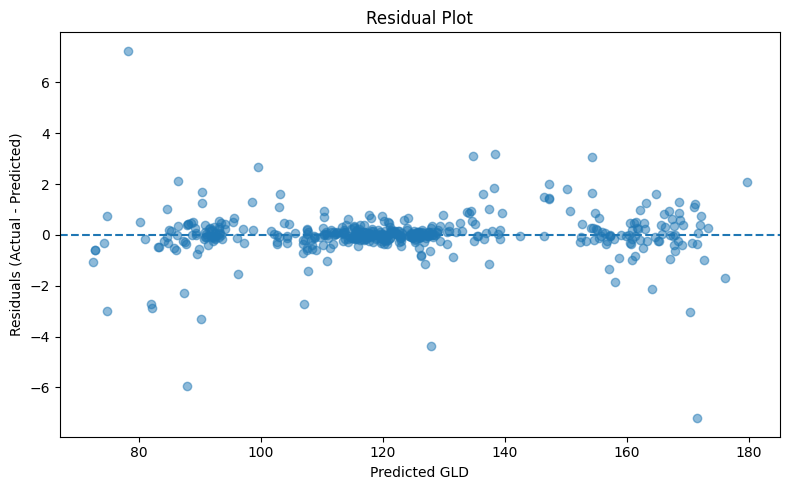

In [ ]:
# Residual plot (Actual - Predicted)
residuals = Y_test - test_data_prediction
plt.figure(figsize=(8, 5))
plt.scatter(test_data_prediction, residuals, alpha=0.5)
plt.axhline(y=0, linestyle='--')
plt.xlabel("Predicted GLD")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.tight_layout()


In [ ]:
# regression metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

mae = mean_absolute_error(Y_test, test_data_prediction)
mse = mean_squared_error(Y_test, test_data_prediction)
rmse = math.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 0.4388288484279453
Mean Squared Error (MSE): 0.8087279432070921
Root Mean Squared Error (RMSE): 0.8992930241067658


Compare the Actual Values and Predicted Values in a Plot

In [ ]:
Y_test = list(Y_test)

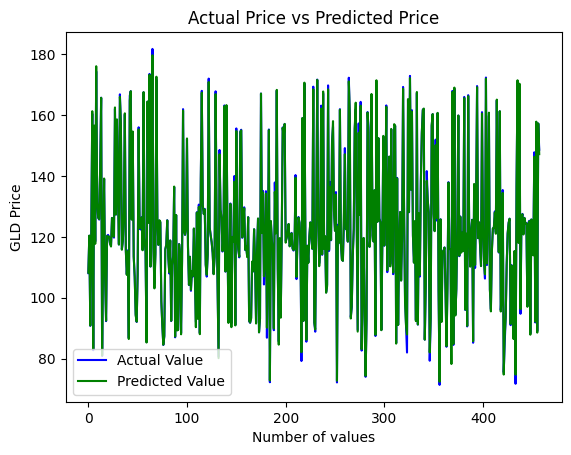

In [ ]:
plt.plot(Y_test, color='blue', label = 'Actual Value')
plt.plot(test_data_prediction, color='green', label='Predicted Value')
plt.title('Actual Price vs Predicted Price')
plt.xlabel('Number of values')
plt.ylabel('GLD Price')
plt.legend()
plt.show()

## Hyperparameter Tuning 

To improve performance, we perform **GridSearchCV** over a small hyperparameter space for the Random Forest model.  
This systematically searches for a better combination of `n_estimators`, `max_depth`, and `min_samples_split`.


In [ ]:
# Hyperparameter tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

rf_base = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=1,
    verbose=1
)

grid_search.fit(X_train, Y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV R2 Score:", grid_search.best_score_)

# Use the best estimator for further predictions
best_rf = grid_search.best_estimator_
tuned_predictions = best_rf.predict(X_test)

tuned_r2 = metrics.r2_score(Y_test, tuned_predictions)
print("Tuned Model R2 on Test Set:", tuned_r2)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best CV R2 Score: 0.9981910194480687
Tuned Model R2 on Test Set: 0.9986445201207798



## Error Analysis & Model Interpretability

We now inspect **feature importances** from the tuned Random Forest model and compare actual vs predicted values.  
This helps us understand **which features drive the predictions** and where the model may still be making larger errors.


         feature  importance
6       GLD_prev    0.995270
7  GLD_prev_diff    0.002296
2            SLV    0.001676
4  SPX_USO_ratio    0.000188
5  SLV_USO_ratio    0.000187
0            SPX    0.000156
3        EUR/USD    0.000122
1            USO    0.000103


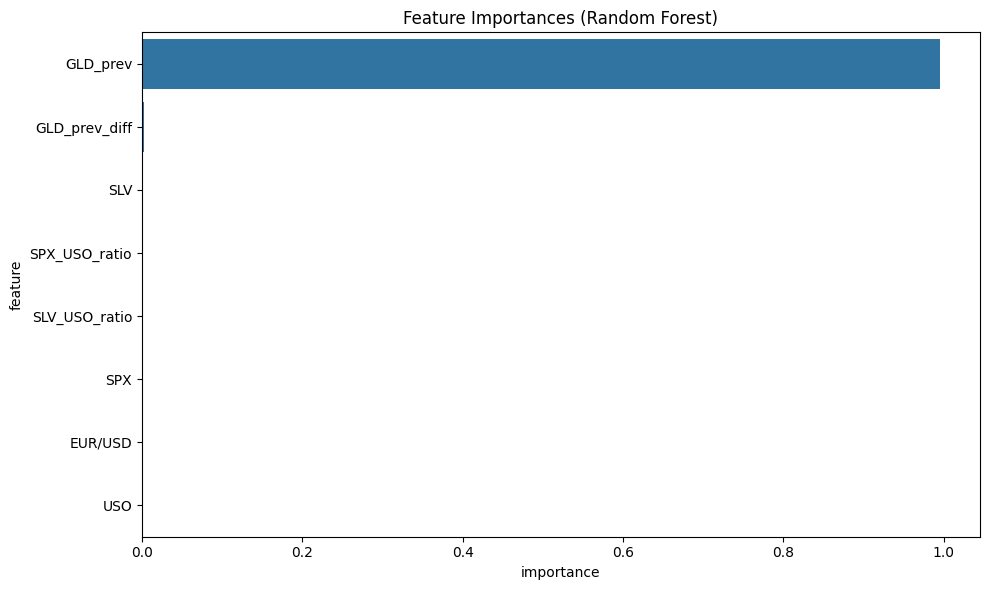

In [ ]:
# Feature importance plot
feature_names = X.columns
importances = best_rf.feature_importances_

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title("Feature Importances (Random Forest)")
plt.tight_layout()
print(importance_df)


#### Interpretability (SHAP)

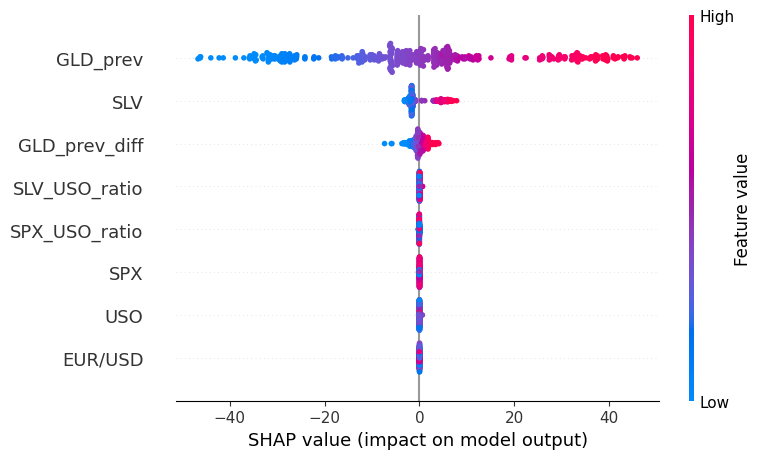

In [ ]:
# SHAP for XGBoost
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_test)

plt.figure()
shap.summary_plot(shap_values, X_test)
plt.show()


Generating SHAP summary for Random Forest... (This may take a moment)


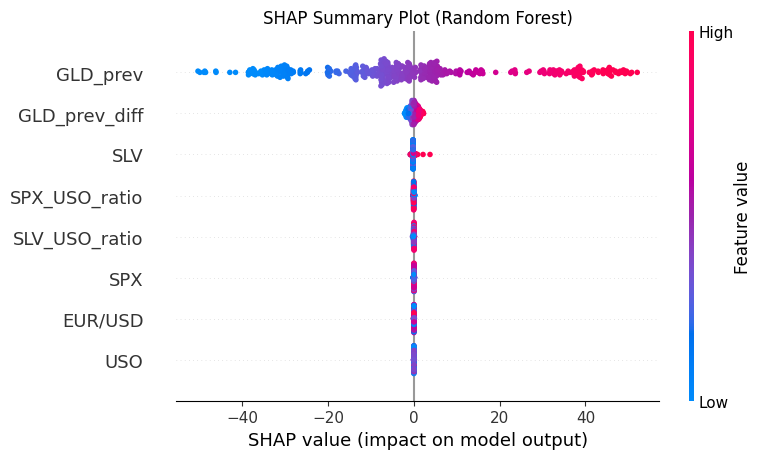

In [ ]:

# --- SHAP for Random Forest ---
print("Generating SHAP summary for Random Forest... (This may take a moment)")
# Use TreeExplainer for Random Forest
rf_explainer = shap.TreeExplainer(best_rf)
rf_shap_values = rf_explainer.shap_values(X_test)

plt.title('SHAP Summary Plot (Random Forest)')
shap.summary_plot(rf_shap_values, X_test)


In [ ]:
# Inspect a few worst error cases
error_abs = np.abs(Y_test - tuned_predictions)
error_analysis_df = pd.DataFrame({
    'Actual_GLD': Y_test,
    'Predicted_GLD': tuned_predictions,
    'Abs_Error': error_abs
}).sort_values(by='Abs_Error', ascending=False)

error_analysis_df.head(10)


,Actual_GLD,Predicted_GLD,Abs_Error
368,85.459999,78.112650,7.347349
292,164.289993,171.455651,7.165658
323,81.989998,87.969699,5.979701
259,123.599998,128.024000,4.424002
181,86.860001,90.165851,3.305850
274,157.320007,154.119398,3.200609
189,137.899994,134.783101,3.116893
437,167.339996,170.382901,3.042905
433,71.709999,74.574700,2.864701
216,79.199997,82.037350,2.837353


## Model Comparison

In [ ]:

    def get_metrics(model, X, y):
        y_pred = model.predict(X)
        r2 = metrics.r2_score(y, y_pred)
        n = X.shape[0]
        p = X.shape[1]
        adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        mae = metrics.mean_absolute_error(y, y_pred)
        mse = metrics.mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)
        return r2, adj_r2, mae, mse, rmse

    models_dict = {
        'Linear Regression': lr_model,
        'Random Forest': best_rf,
        'XGBoost': best_xgb
    }

    summary_data = {
        'Algorithm': [],
        'Train R2': [], 'Test R2': [],
        'Train Adj R2': [], 'Test Adj R2': [],
        'Train MAE': [], 'Test MAE': [],
        'Train MSE': [], 'Test MSE': [],
        'Train RMSE': [], 'Test RMSE': [] 
    }

    for name, model in models_dict.items():
    
        tr_r2, tr_adj_r2, tr_mae, tr_mse, tr_rmse = get_metrics(model, X_train_scaled if name == 'Linear Regression' else X_train, Y_train)
        
        te_r2, te_adj_r2, te_mae, te_mse, te_rmse = get_metrics(model, X_test_scaled if name == 'Linear Regression' else X_test, Y_test)
        
        summary_data['Algorithm'].append(name)
        summary_data['Train R2'].append(tr_r2)
        summary_data['Test R2'].append(te_r2)
        summary_data['Train Adj R2'].append(tr_adj_r2)
        summary_data['Test Adj R2'].append(te_adj_r2)
        summary_data['Train MAE'].append(tr_mae)
        summary_data['Test MAE'].append(te_mae)
        summary_data['Train MSE'].append(tr_mse)
        summary_data['Test MSE'].append(te_mse)
        summary_data['Train RMSE'].append(tr_rmse)
        summary_data['Test RMSE'].append(te_rmse)

    summary_df = pd.DataFrame(summary_data)
    print("\n--- Comprehensive Model Evaluation Summary ---\n")

    display(summary_df.style.background_gradient(cmap='Blues'))



--- Comprehensive Model Evaluation Summary ---



,Algorithm,Train R2,Test R2,Train Adj R2,Test Adj R2,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE
0,Linear Regression,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Random Forest,0.999817,0.998645,0.999816,0.998620,0.147263,0.434208,0.097337,0.793199,0.311989,0.890617
2,XGBoost,0.999731,0.999461,0.999730,0.999452,0.270435,0.364551,0.142819,0.315272,0.377914,0.561491
